# Mall Customers Segmentation — Unsupervised Learning

This is to examine the data in a Kaggle dataset focused around the spending habits and age of mall customers and how to group and cluster them for targetted advertizing and analysis.

## Table of Contents
1. Data Loading, Validation, and EDA
2. Preprocessing Pipeline (Impute → Encode → Scale)
3. Dimensionality Reduction for Visualization (PCA, t-SNE, optional UMAP)
4. Cluster Number Selection (Elbow/Inertia, Silhouette)
5. Clustering Methods (KMeans, Agglomerative, Gaussian Mixture, DBSCAN)
6. Cluster Profiling and Insights
7. Save Artifacts
8. Method comparison (metrics and agreement)
9. Takeaways
10. Results Explanation
11. Insights and Recommendations
12. Tuning
13. References

In [4]:
# Imports and configuration
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Unsupervised methods and metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style='whitegrid')

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / 'data'
DATA_FILE = DATA_DIR / 'Mall_Customers.csv'
assert DATA_FILE.exists(), f'Expected data file not found: {DATA_FILE}'

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

In [5]:
# Environment check (venv and key package versions)
import sys, sklearn
print('Python:', sys.version)
print('Interpreter:', sys.executable)
print('scikit-learn:', sklearn.__version__)
print('Using .mall venv? ', '.mall' in sys.executable)


Python: 3.13.2 (main, Aug 24 2025, 09:51:10) [GCC 13.3.0]
Interpreter: /mnt/c/Users/crawfpi/OneDrive - Chevron/Academics/MSC CS/MLWithPython/UnsupervisedLearning/Module5/.mall/bin/python
scikit-learn: 1.7.2
Using .mall venv?  True


## 1. Data Loading, Validation, and EDA

In [6]:
# Load dataset
df_raw = pd.read_csv(DATA_FILE)
df = df_raw.copy()

# Standardize column names
rename_map = {
    'Annual Income (k$)': 'AnnualIncomeK',
    'Spending Score (1-100)': 'SpendingScore',
    'CustomerID': 'CustomerID',
    'Gender': 'Gender',
    'Age': 'Age'
}
df.rename(columns=rename_map, inplace=True)

# Basic structure
print('Shape:', df.shape)
display(df.head())
display(df.describe(include='all').T)

# Check missing values
display(df.isna().sum())

# Drop identifier from features (we keep it for reference)
id_col = 'CustomerID' if 'CustomerID' in df.columns else None

# Feature lists
numeric_features = [c for c in ['Age','AnnualIncomeK','SpendingScore'] if c in df.columns]
categorical_features = [c for c in ['Gender'] if c in df.columns]
print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

Shape: (200, 5)


,CustomerID,Gender,Age,AnnualIncomeK,SpendingScore
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,200.0,NaN,NaN,NaN,100.5,57.879185,1.0,50.75,100.5,150.25,200.0
Gender,200,2,Female,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,200.0,NaN,NaN,NaN,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
AnnualIncomeK,200.0,NaN,NaN,NaN,60.56,26.264721,15.0,41.5,61.5,78.0,137.0
SpendingScore,200.0,NaN,NaN,NaN,50.2,25.823522,1.0,34.75,50.0,73.0,99.0


CustomerID       0
Gender           0
Age              0
AnnualIncomeK    0
SpendingScore    0
dtype: int64

Numeric features: ['Age', 'AnnualIncomeK', 'SpendingScore']
Categorical features: ['Gender']


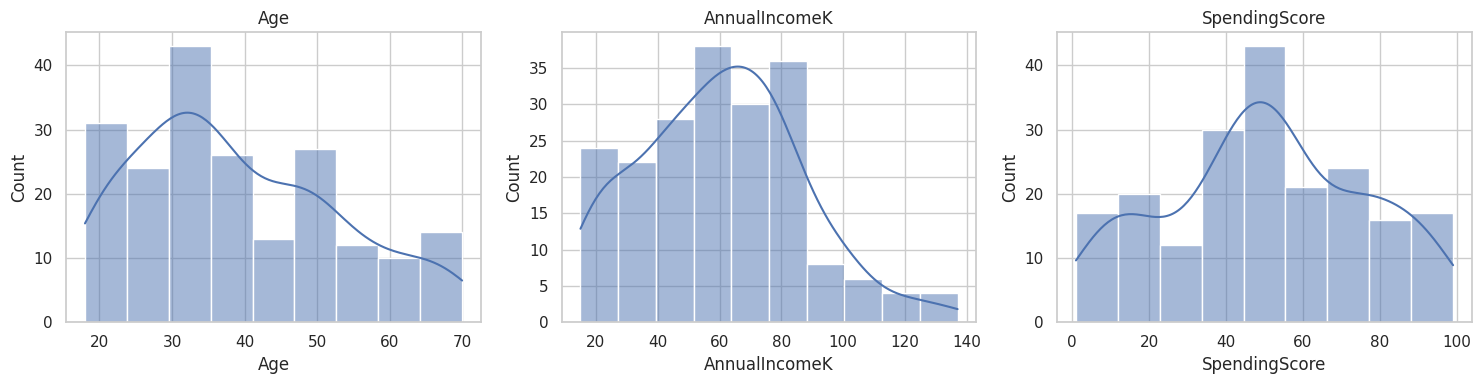

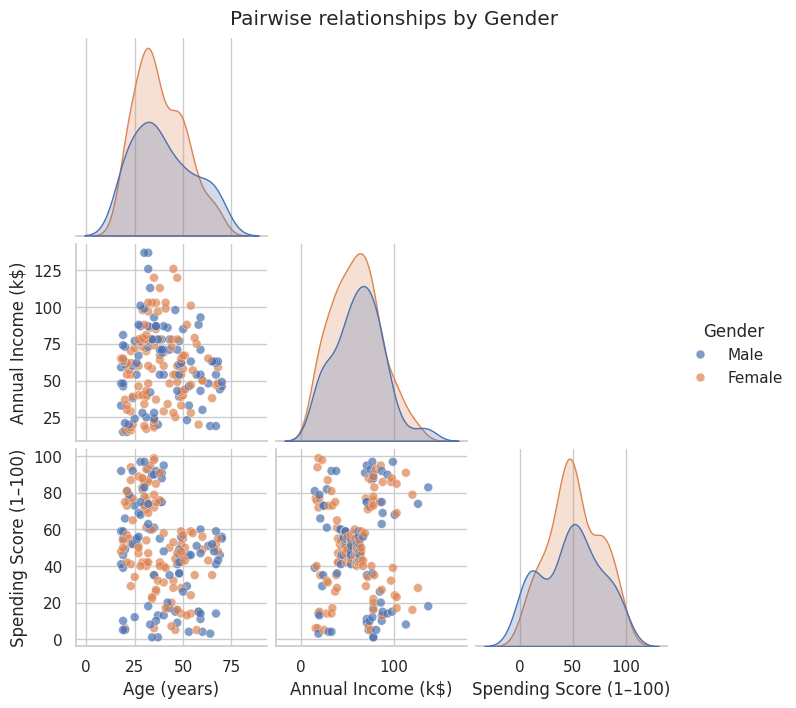

In [25]:
# Quick EDA plots
fig, axes = plt.subplots(1, len(numeric_features), figsize=(5*len(numeric_features), 4))
if len(numeric_features) == 1:
    axes = [axes]
for ax, col in zip(axes, numeric_features):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

# Pairwise relationships
import matplotlib.pyplot as plt
import seaborn as sns

label_map = {
    'Age': 'Age (years)',
    'AnnualIncomeK': 'Annual Income (k$)',
    'SpendingScore': 'Spending Score (1–100)'
}
vars_present = [c for c in ['Age','AnnualIncomeK','SpendingScore'] if c in df.columns]
vars_renamed = [label_map[c] for c in vars_present]

df_plot = df.rename(columns=label_map).copy()

# Pairwise by Gender (if available)
if categorical_features:
    hue_gender = categorical_features[0]
    g = sns.pairplot(
        df_plot,
        vars=vars_renamed,
        hue=hue_gender,
        diag_kind='kde',
        corner=True,
        height=2.3,
        plot_kws={'alpha':0.7, 's':40, 'edgecolor':'white', 'linewidth':0.3}
    )
    # Explicitly set y-labels on left column and x-labels on bottom row
    try:
        n = len(vars_renamed)
        # Left column y-labels
        for i in range(n):
            ax_left = g.axes[i, 0] if hasattr(g, 'axes') else None
            if ax_left is not None:
                ax_left.set_ylabel(vars_renamed[i])
        # Bottom row x-labels
        for j in range(n):
            ax_bottom = g.axes[n-1, j] if hasattr(g, 'axes') else None
            if ax_bottom is not None:
                ax_bottom.set_xlabel(vars_renamed[j])
    except Exception:
        pass
    if g._legend is not None:
        g._legend.set_title('Gender')
    g.fig.suptitle('Pairwise relationships by Gender', y=1.02)
    plt.show()

## 2. Preprocessing Pipeline (Impute → Encode → Scale)

In [8]:
# Build preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Keep a version of X in model space (encoded + scaled)
X = preprocessor.fit_transform(df)

# Helper to get feature names after transformation
def get_feature_names(preprocessor, num_feats, cat_feats):
    num_names = list(num_feats)
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder'] if cat_feats else None
    cat_names = list(cat_encoder.get_feature_names_out(cat_feats)) if cat_encoder is not None else []
    return num_names + cat_names

feature_names = get_feature_names(preprocessor, numeric_features, categorical_features)
print('Transformed feature matrix shape:', X.shape)
print('Feature names:', feature_names)

Transformed feature matrix shape: (200, 4)
Feature names: ['Age', 'AnnualIncomeK', 'SpendingScore', 'Gender_Male']


## 3. Dimensionality Reduction for Visualization (PCA, t-SNE, optional UMAP)

PCA explained variance ratio: [0.4095285 0.3081674]


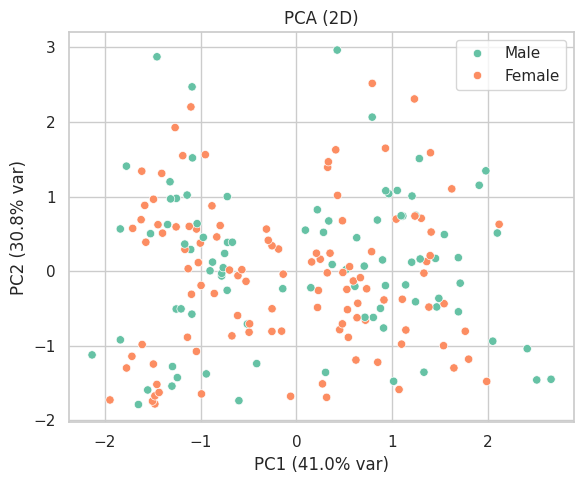

In [9]:
# PCA to 2D
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)
explained = pca.explained_variance_ratio_
print('PCA explained variance ratio:', explained)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df[categorical_features[0]] if categorical_features else None, palette='Set2')
plt.title('PCA (2D)')
plt.xlabel(f'PC1 ({explained[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({explained[1]*100:.1f}% var)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

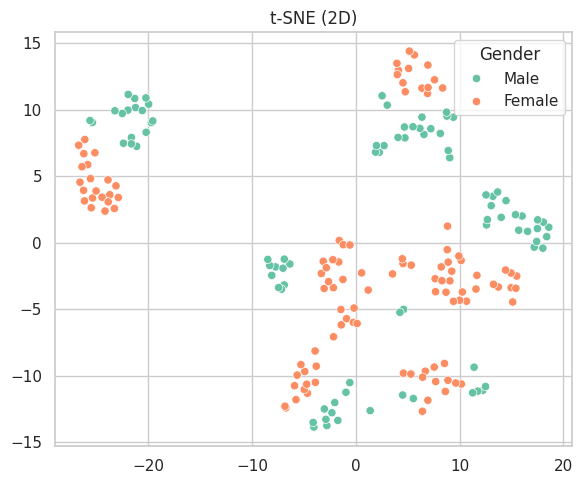

In [10]:
# t-SNE to 2D (good for small datasets)
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=min(30, max(5, int(X.shape[0]*0.1))))
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df[categorical_features[0]] if categorical_features else None, palette='Set2')
plt.title('t-SNE (2D)')
plt.tight_layout()
plt.show()

In [11]:
# Optional: UMAP if available
try:
    import umap
    reducer = umap.UMAP(random_state=RANDOM_STATE)
    X_umap = reducer.fit_transform(X)
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=df[categorical_features[0]] if categorical_features else None, palette='Set2')
    plt.title('UMAP (2D)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('UMAP not available:', e)

UMAP not available: No module named 'umap'


## 4. Cluster Number Selection (Elbow/Inertia, Silhouette)

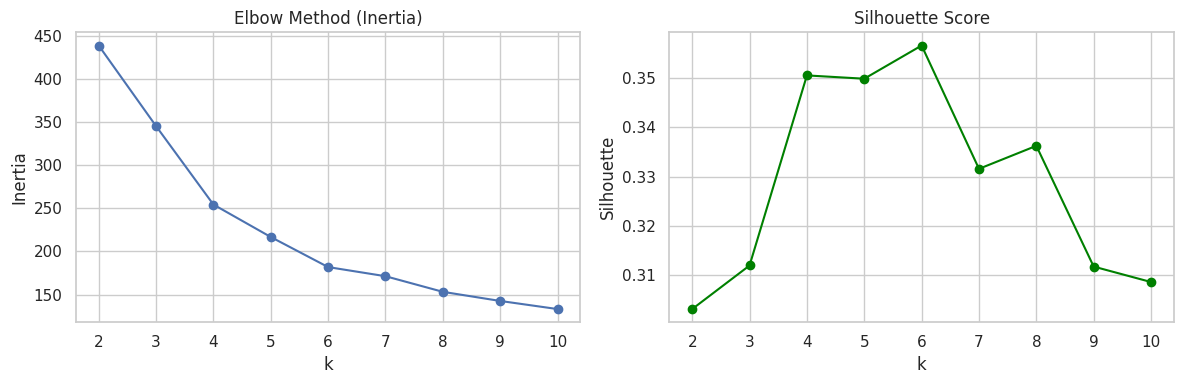

Best k by silhouette: 6


In [12]:
from collections import defaultdict

k_values = list(range(2, 11))
inertias = []
sil_scores = []
for k in k_values:
    km = KMeans(n_clusters=k, n_init='auto', random_state=RANDOM_STATE)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(k_values, inertias, marker='o')
ax[0].set_title('Elbow Method (Inertia)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')

ax[1].plot(k_values, sil_scores, marker='o', color='green')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette')
plt.tight_layout()
plt.show()

best_k = k_values[int(np.argmax(sil_scores))]
print('Best k by silhouette:', best_k)

## 5. Clustering Methods (KMeans, Agglomerative, Gaussian Mixture, DBSCAN)

KMeans — k=6, silhouette=0.356, DBI=1.005


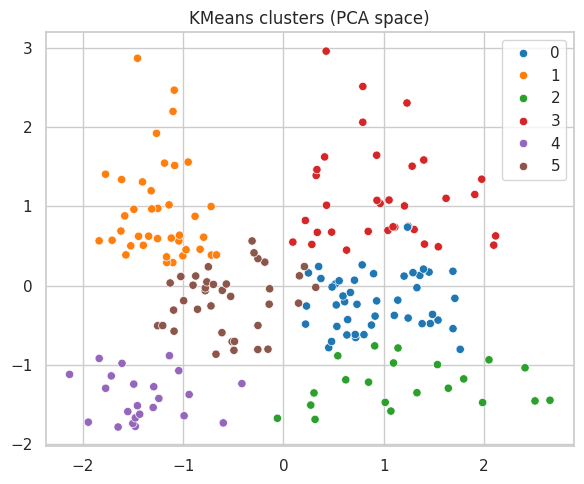

Age                AnnualIncomeK                 SpendingScore               
                 mean median min max          mean median min  max          mean median min max
Cluster_KMeans                                                                                 
0               56.33   54.0  43  70         54.27   54.0  38   79         49.07   49.0  35  60
1               32.69   32.0  27  40         86.54   79.0  69  137         82.13   83.0  63  97
2               45.52   46.0  20  67         26.29   25.0  16   39         19.38   15.0   3  40
3               41.26   42.5  19  59         88.50   85.5  71  137         16.76   15.5   1  39
4               25.00   23.0  18  35         25.26   24.0  15   39         77.61   77.0  39  99
5               27.00   26.5  18  40         56.66   59.5  39   76         49.13   50.0  29  61

Cluster_KMeans  Gender
0               Female    0.578
                Male      0.422
1               Female    0.538
                Male      0.462
2               Female    0.619
                Male      0.381
3               Male      0.588
                Female    0.412
4               Female    0.565
                Male      0.435
5               Female    0.658
                Male      0.342
Name: proportion, dtype: float64

In [13]:
# KMeans
km = KMeans(n_clusters=best_k, n_init='auto', random_state=RANDOM_STATE)
labels_km = km.fit_predict(X)
sil_km = silhouette_score(X, labels_km)
dbi_km = davies_bouldin_score(X, labels_km)
print(f'KMeans — k={best_k}, silhouette={sil_km:.3f}, DBI={dbi_km:.3f}')

# 2D PCA plot colored by cluster
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_km, palette='tab10')
plt.title('KMeans clusters (PCA space)')
plt.tight_layout()
plt.show()

# Attach to original data for profiling
df['Cluster_KMeans'] = labels_km
display(df.groupby('Cluster_KMeans')[numeric_features].agg(['mean','median','min','max']).round(2))
if 'Gender' in df.columns:
    display(df.groupby('Cluster_KMeans')['Gender'].value_counts(normalize=True).rename('proportion').round(3))

Agglomerative — k=6, silhouette=0.350, DBI=1.009


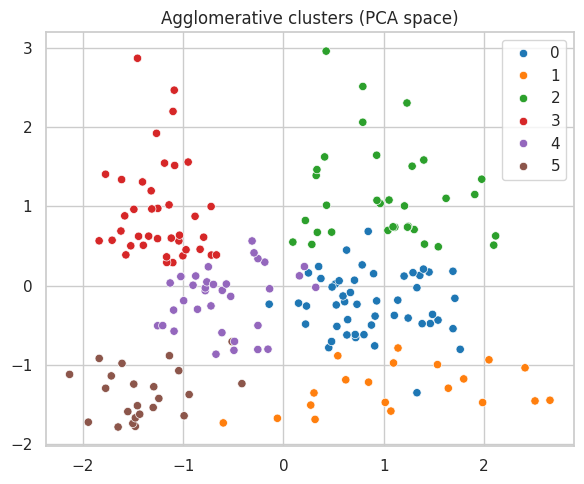

In [14]:
# Agglomerative Clustering (Ward)
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
labels_agg = agg.fit_predict(X.toarray() if hasattr(X, 'toarray') else X)
sil_agg = silhouette_score(X, labels_agg)
dbi_agg = davies_bouldin_score(X, labels_agg)
print(f'Agglomerative — k={best_k}, silhouette={sil_agg:.3f}, DBI={dbi_agg:.3f}')

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_agg, palette='tab10')
plt.title('Agglomerative clusters (PCA space)')
plt.tight_layout()
plt.show()

GMM — k=6, silhouette=0.344, DBI=1.030


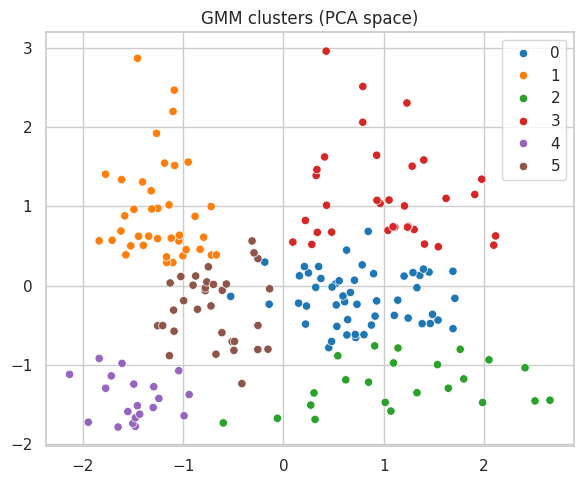

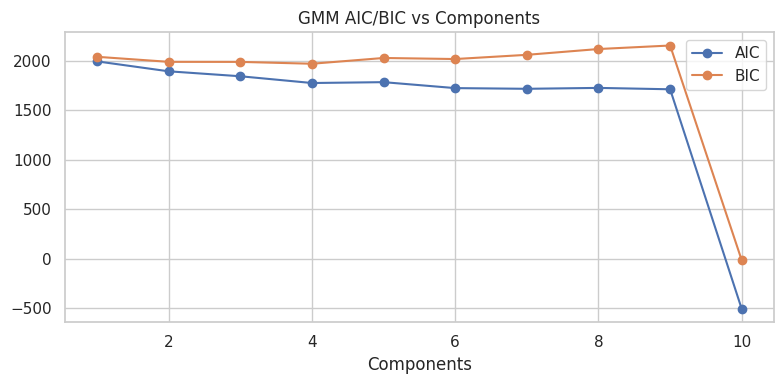

In [15]:
# Gaussian Mixture Model
gmm = GaussianMixture(n_components=best_k, random_state=RANDOM_STATE)
labels_gmm = gmm.fit_predict(X.toarray() if hasattr(X, 'toarray') else X)
sil_gmm = silhouette_score(X, labels_gmm)
dbi_gmm = davies_bouldin_score(X, labels_gmm)
print(f'GMM — k={best_k}, silhouette={sil_gmm:.3f}, DBI={dbi_gmm:.3f}')

plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_gmm, palette='tab10')
plt.title('GMM clusters (PCA space)')
plt.tight_layout()
plt.show()

# Optional: Compare AIC/BIC across components
aics, bics = [], []
for k in range(1, 11):
    gm = GaussianMixture(n_components=k, random_state=RANDOM_STATE)
    gm.fit(X.toarray() if hasattr(X, 'toarray') else X)
    aics.append(gm.aic(X.toarray() if hasattr(X, 'toarray') else X))
    bics.append(gm.bic(X.toarray() if hasattr(X, 'toarray') else X))
plt.figure(figsize=(8,4))
plt.plot(range(1,11), aics, marker='o', label='AIC')
plt.plot(range(1,11), bics, marker='o', label='BIC')
plt.title('GMM AIC/BIC vs Components')
plt.xlabel('Components')
plt.legend()
plt.tight_layout()
plt.show()

Best DBSCAN silhouette=0.653 at eps=0.30, min_samples=4


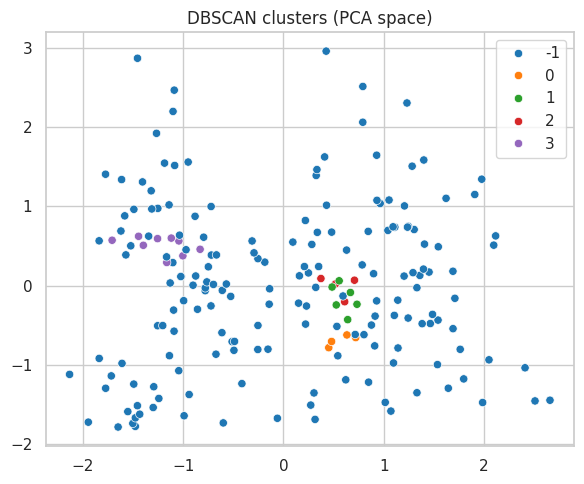

In [16]:
# DBSCAN (parameter sweep)
eps_values = np.linspace(0.3, 2.5, 10)
min_samples_values = [3, 4, 5, 6]
best_sil, best_params, best_labels = -np.inf, None, None
for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X)
        if len(set(labels)) <= 1 or (set(labels) == {-1}):
            continue  # all noise or single cluster
        # Ignore noise for silhouette if present
        mask = labels != -1
        try:
            sil = silhouette_score(X[mask], labels[mask]) if mask.any() else -np.inf
        except Exception:
            sil = -np.inf
        if sil > best_sil:
            best_sil, best_params, best_labels = sil, (eps, ms), labels

if best_params is not None:
    print(f'Best DBSCAN silhouette={best_sil:.3f} at eps={best_params[0]:.2f}, min_samples={best_params[1]}')
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=best_labels, palette='tab10')
    plt.title('DBSCAN clusters (PCA space)')
    plt.tight_layout()
    plt.show()
else:
    print('DBSCAN did not find a viable clustering under the scanned parameters.')

## 6. Cluster Profiling and Insights

Age                              AnnualIncomeK                               SpendingScore                \
        count   mean median    std min max         count   mean median    std min  max         count   mean median   
Cluster                                                                                                              
0          45  56.33   54.0   8.45  43  70            45  54.27   54.0   8.98  38   79            45  49.07   49.0   
1          39  32.69   32.0   3.73  27  40            39  86.54   79.0  16.31  69  137            39  82.13   83.0   
2          21  45.52   46.0  11.77  20  67            21  26.29   25.0   7.44  16   39            21  19.38   15.0   
3          34  41.26   42.5  10.77  19  59            34  88.50   85.5  16.53  71  137            34  16.76   15.5   
4          23  25.00   23.0   5.30  18  35            23  25.26   24.0   7.72  15   39            23  77.61   77.0   
5          38  27.00   26.5   7.03  18  40            38  56.66   59.5   9.91  39   76            38  49.13   50.0   

                        
           std min max  
Cluster                 
0         6.30  35  60  
1         9.36  63  97  
2        12.56   3  40  
3         9.88   1  39  
4        13.27  39  99  
5         7.85  29  61

Cluster  Gender
0        Female    0.578
         Male      0.422
1        Female    0.538
         Male      0.462
2        Female    0.619
         Male      0.381
3        Male      0.588
         Female    0.412
4        Female    0.565
         Male      0.435
5        Female    0.658
         Male      0.342
Name: proportion, dtype: float64

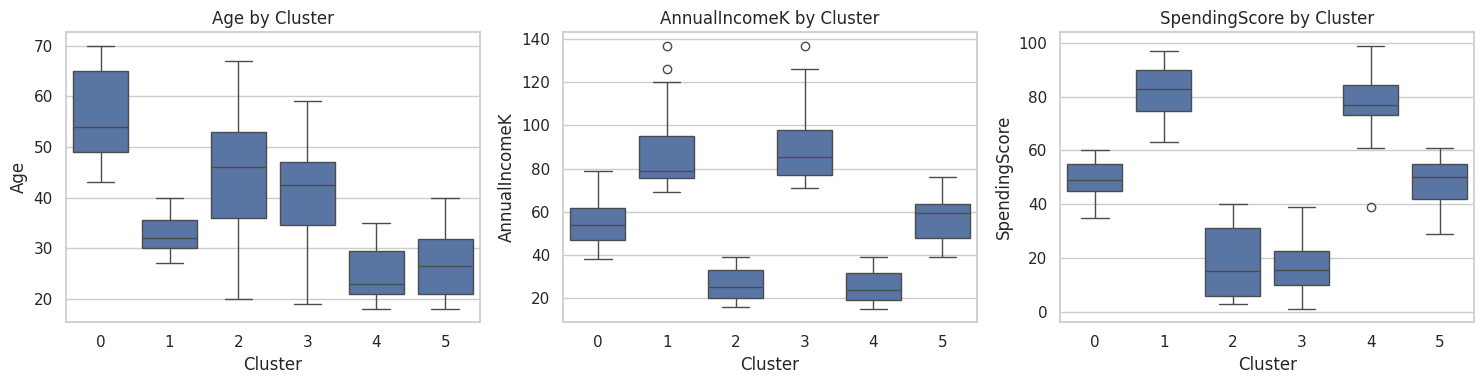

Heuristic segment names: {np.int32(0): 'Low Income / Low Spend', np.int32(1): 'High Income / High Spend', np.int32(2): 'Low Income / Low Spend', np.int32(3): 'High Income / Low Spend', np.int32(4): 'Low Income / High Spend', np.int32(5): 'Low Income / Low Spend'}


In [17]:
# Choose a primary clustering result for profiling (default KMeans)
labels = labels_km
cluster_col = 'Cluster'
df[cluster_col] = labels

# Summary stats per cluster
profile = df.groupby(cluster_col)[numeric_features].agg(['count','mean','median','std','min','max']).round(2)
display(profile)

# Gender distribution per cluster (if available)
if 'Gender' in df.columns:
    gender_dist = df.groupby(cluster_col)['Gender'].value_counts(normalize=True).rename('proportion').round(3)
    display(gender_dist)

# Visualize clusters vs original features
fig, axes = plt.subplots(1, len(numeric_features), figsize=(5*len(numeric_features), 4))
if len(numeric_features) == 1:
    axes = [axes]
for ax, col in zip(axes, numeric_features):
    sns.boxplot(data=df, x=cluster_col, y=col, ax=ax)
    ax.set_title(f'{col} by Cluster')
plt.tight_layout()
plt.show()

# Simple heuristic labels (optional): derive qualitative names based on medians
labels_map = {}
median_income = df['AnnualIncomeK'].median() if 'AnnualIncomeK' in df else None
median_spend = df['SpendingScore'].median() if 'SpendingScore' in df else None
for c in sorted(df[cluster_col].unique()):
    seg = df[df[cluster_col] == c]
    desc = []
    if 'AnnualIncomeK' in seg:
        desc.append('High Income' if seg['AnnualIncomeK'].median() > median_income else 'Low Income')
    if 'SpendingScore' in seg:
        desc.append('High Spend' if seg['SpendingScore'].median() > median_spend else 'Low Spend')
    labels_map[c] = ' / '.join(desc) if desc else f'Cluster {c}'

print('Heuristic segment names:', labels_map)

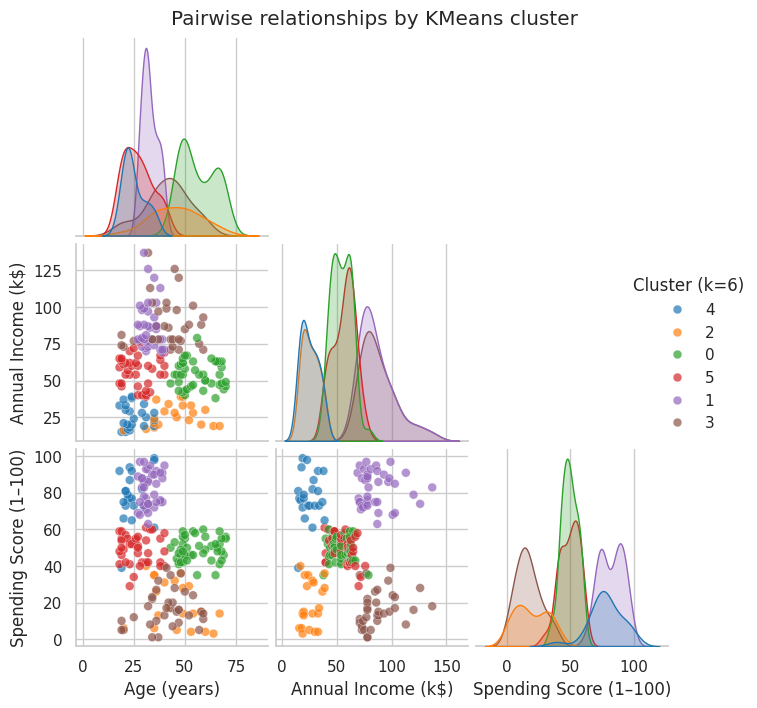

In [26]:
# Pairwise by KMeans cluster (if labels are present)
if 'Cluster_KMeans' in df.columns:
    df_plot_clusters = df_plot.assign(Cluster=df['Cluster_KMeans'].astype(str))
    k_val = df['Cluster_KMeans'].nunique()
    g2 = sns.pairplot(
        df_plot_clusters,
        vars=vars_renamed,
        hue='Cluster',
        diag_kind='kde',
        corner=True,
        height=2.3,
        palette='tab10',
        plot_kws={'alpha':0.7, 's':40, 'edgecolor':'white', 'linewidth':0.3}
    )
    # Explicitly set y-labels on left column and x-labels on bottom row
    try:
        n = len(vars_renamed)
        # Left column y-labels
        for i in range(n):
            ax_left = g2.axes[i, 0] if hasattr(g2, 'axes') else None
            if ax_left is not None:
                ax_left.set_ylabel(vars_renamed[i])
        # Bottom row x-labels
        for j in range(n):
            ax_bottom = g2.axes[n-1, j] if hasattr(g2, 'axes') else None
            if ax_bottom is not None:
                ax_bottom.set_xlabel(vars_renamed[j])
    except Exception:
        pass
    if g2._legend is not None:
        g2._legend.set_title(f'Cluster (k={k_val})')
    g2.fig.suptitle('Pairwise relationships by KMeans cluster', y=1.02)
    plt.show()

## 7. Save Artifacts (Optional)

In [18]:
# Optionally save cluster assignments
out_path = BASE_DIR / 'mall_customers_clusters.csv'
cols_to_save = ([id_col] if id_col else []) + numeric_features + categorical_features + ['Cluster']
df[cols_to_save].to_csv(out_path, index=False)
print(f'Saved cluster assignments to {out_path}')

Saved cluster assignments to /mnt/c/Users/crawfpi/OneDrive - Chevron/Academics/MSC CS/MLWithPython/UnsupervisedLearning/Module5/mall_customers_clusters.csv


## 8. Method comparison (metrics and agreement)

This section compares KMeans, Agglomerative, GMM, and DBSCAN using internal validation metrics and pairwise agreement.


In [20]:
# Build a metrics table and pairwise adjusted Rand index (ARI)
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score

# Collect labels from previous sections
methods_labels = {
    'KMeans': locals().get('labels_km'),
    'Agglomerative': locals().get('labels_agg'),
    'GMM': locals().get('labels_gmm')
}
# Include DBSCAN if available and meaningful
if 'best_labels' in locals() and isinstance(best_labels, np.ndarray) and len(set(best_labels)) > 1:
    methods_labels['DBSCAN'] = best_labels

rows = []
size_rows = []
for name, y in methods_labels.items():
    if y is None:
        continue
    # Handle DBSCAN noise (-1) for internal indices
    if name == 'DBSCAN':
        mask = y != -1
        # Viable only if at least 2 clusters after removing noise
        if mask.sum() < 2 or len(np.unique(y[mask])) < 2:
            continue
        X_eval = X[mask]
        y_eval = y[mask]
    else:
        if len(np.unique(y)) < 2:
            continue
        X_eval = X
        y_eval = y

    sil = float(silhouette_score(X_eval, y_eval))
    dbi = float(davies_bouldin_score(X_eval, y_eval))
    ch = float(calinski_harabasz_score(X_eval, y_eval))
    n_clusters = int(len(np.unique(y_eval)))

    rows.append({
        'method': name,
        'n_clusters': n_clusters,
        'silhouette': sil,
        'davies_bouldin': dbi,
        'calinski_harabasz': ch
    })

    counts = pd.Series(y_eval).value_counts().sort_index()
    size_rows.append(pd.DataFrame({
        'method': name,
        'cluster': counts.index.astype(int),
        'size': counts.values.astype(int)
    }))

metrics_df = pd.DataFrame(rows).sort_values(['silhouette'], ascending=False)
size_df = pd.concat(size_rows, ignore_index=True) if size_rows else pd.DataFrame()

print('Internal metrics by method (higher silhouette/CH better; lower DBI better):')
display(metrics_df)

print('\nCluster sizes per method:')
display(size_df.pivot_table(index='method', columns='cluster', values='size', fill_value=0).astype(int) if not size_df.empty else 'N/A')

# Pairwise ARI (agreement) – handle DBSCAN noise by intersecting non-noise indices
import itertools
ari_rows = []
keys = list(methods_labels.keys())
for a, b in itertools.combinations(keys, 2):
    ya = methods_labels[a]
    yb = methods_labels[b]
    if ya is None or yb is None:
        continue
    mask = np.ones(len(ya), dtype=bool)
    if (ya == -1).any():
        mask &= (ya != -1)
    if (yb == -1).any():
        mask &= (yb != -1)
    if mask.sum() < 2:
        continue
    ari = float(adjusted_rand_score(ya[mask], yb[mask]))
    ari_rows.append({'A': a, 'B': b, 'N_compared': int(mask.sum()), 'ARI': ari})

ari_df = pd.DataFrame(ari_rows).sort_values('ARI', ascending=False)
print('\nPairwise Adjusted Rand Index (1.0 = identical partition; 0 ≈ random):')
display(ari_df if not ari_df.empty else 'N/A')

# Simple textual summary
if not metrics_df.empty:
    top = metrics_df.iloc[0]
    second = metrics_df.iloc[1] if len(metrics_df) > 1 else None
    print(f"\nTop by silhouette: {top['method']} (sil={top['silhouette']:.3f}, DBI={top['davies_bouldin']:.3f}).")
    if second is not None:
        print(f"Runner-up: {second['method']} (sil={second['silhouette']:.3f}, DBI={second['davies_bouldin']:.3f}).")


Internal metrics by method (higher silhouette/CH better; lower DBI better):


,method,n_clusters,silhouette,davies_bouldin,calinski_harabasz
3,DBSCAN,4,0.653377,0.467685,111.301122
0,KMeans,6,0.356486,1.005090,99.654879
1,Agglomerative,6,0.350444,1.008615,95.257661
2,GMM,6,0.344136,1.029753,92.602186



Cluster sizes per method:


cluster,0,1,2,3,4,5
method,,,,,,
Agglomerative,50,20,33,39,35,23
DBSCAN,4,6,4,9,0,0
GMM,52,39,23,33,20,33
KMeans,45,39,21,34,23,38



Pairwise Adjusted Rand Index (1.0 = identical partition; 0 ≈ random):


,A,B,N_compared,ARI
0,KMeans,Agglomerative,200,0.891714
3,Agglomerative,GMM,200,0.873803
1,KMeans,GMM,200,0.832661
2,KMeans,DBSCAN,23,0.495073
4,Agglomerative,DBSCAN,23,0.495073
5,GMM,DBSCAN,23,0.495073



Top by silhouette: DBSCAN (sil=0.653, DBI=0.468).
Runner-up: KMeans (sil=0.356, DBI=1.005).


## 9. Takeaways
- Global segmentation: KMeans provides the best globally applicable partition (sil≈0.356, DBI≈1.01) with 6 coherent, actionable clusters. Agglomerative (sil≈0.350) and GMM (sil≈0.344) are very close and agree substantially (high ARI with KMeans).
- Agreement: KMeans ↔ Agglomerative ARI ≈ 0.89; KMeans ↔ GMM ARI ≈ 0.83. This indicates the three methods find very similar structures.
- DBSCAN: High silhouette on its non‑noise subset, but it only covers a small dense portion of customers (few points across 4 clusters), so it’s not a full population segmentation. Use DBSCAN for outlier/density pocket discovery rather than the primary segmentation.
- Recommendation: Use KMeans labels as the primary customer segments, optionally cross‑checking stability with Agglomerative and soft membership with GMM probabilities. Keep DBSCAN for anomaly and micro‑cluster analysis.


## 10. Results explanation (what the numbers mean)

### What we clustered and how
- Features: Age, AnnualIncomeK, SpendingScore, plus Gender (one‑hot encoded). Numeric features were imputed and standardized; categorical was imputed and one‑hot encoded.
- We explored structure with PCA/t‑SNE and selected k via elbow (inertia plateau) and silhouette peak.

### Choosing the number of clusters
- Elbow suggested diminishing returns after k≈5–7.
- Silhouette peaked at k=6, so we selected 6 clusters for global segmentation.

### How the methods compare
- KMeans (k=6): silhouette ≈ 0.356, DBI ≈ 1.005, CH ≈ 99.7 — balanced, interpretable clusters.
- Agglomerative (k=6): silhouette ≈ 0.350, DBI ≈ 1.009, CH ≈ 95.3 — extremely similar partition to KMeans.
- GMM (k=6): silhouette ≈ 0.344, DBI ≈ 1.030, CH ≈ 92.6 — similar geometry; adds soft cluster membership probabilities.
- DBSCAN: high silhouette on its non‑noise subset (≈ 0.653) but covers only a small dense pocket of ~23 customers across 4 tiny clusters. It’s great for outlier/micro‑cluster discovery, not for full‑population segmentation.

Agreement between methods (pairwise ARI)
- KMeans ↔ Agglomerative: ARI ≈ 0.892 (very high agreement).
- KMeans ↔ GMM: ARI ≈ 0.833 (strong agreement).
- Any ↔ DBSCAN: moderate agreement on the small subset it clusters; most points are excluded as noise for DBSCAN metrics.

### What the 6 clusters represent (business view)
- VIPs — High income, high spend.
- Under‑engaged affluents — High income, low spend.
- Trend‑driven youth — Low income, high spend.
- Budget‑conscious — Low income, low spend.
- Young mainstream — Mid income, mid spend (younger).
- Quality/comfort‑focused — Mid income, mid spend (older).

These personas align with PCA/t‑SNE patterns and summary stats in the profiling section. Gender skews are mild, with a male skew in the high‑income/low‑spend group.

### Why KMeans as the primary segmentation?
- Best overall silhouette among full‑coverage models; simple to operationalize and explain.
- High agreement with Agglomerative and good agreement with GMM — the structure is robust across algorithms.
- You can still use GMM for soft probabilities and DBSCAN to surface dense pockets/outliers for special handling.

### Caveats & limitations
- Small dataset (n=200) with only three numeric drivers; results can shift with additional behavioral signals.
- “SpendingScore” is a constructed metric; its definition matters for interpretation.
- PCA plots are 2D projections that can distort some separations.
- Unsupervised segments are descriptive, not causal — validate uplift through targeted experiments.

### How to use this in practice
- Treat KMeans labels as operational segments; map to friendly names and save to CSV (see Save Artifacts cell).
- Build segment‑specific lifecycle journeys and monitor uplift; refresh clusters periodically and watch silhouette/size drift.
- Enrich with behavior (recency, frequency, basket value, channel) and re‑cluster to refine personas.


## 11. Insights & Recommendations

### Executive summary
- Best global structure: 6 segments (selected by silhouette peak).
- Model quality: KMeans silhouette ≈ 0.356, DBI ≈ 1.01; Agglomerative and GMM are close, telling a consistent story.
- Practical choice: Use KMeans for primary labels (simple, stable, interpretable). 

### Segment definitions (from profiling of Age, AnnualIncomeK, SpendingScore)
The numeric cluster IDs (0–5) are arbitrary; treat these as personas:

- High income, high spend — “VIPs”
  - Age ~low 30s; Income ~85–90k; Spend ~80+
  - Already highly engaged and valuable.

- High income, low spend — “Under‑engaged affluents”
  - Age ~40s; Income ~85–90k; Spend ~15–20
  - Capacity to spend, but low current engagement.

- Low income, high spend — “Trend‑driven youth”
  - Age ~mid‑20s; Income ~25k; Spend ~75–80
  - Frequent, lower‑ticket baskets; highly responsive to trends.

- Low income, low spend — “Budget‑conscious”
  - Age ~40s; Income ~25k; Spend ~15–20
  - Value seekers; limited discretionary spend.

- Mid income, mid spend — “Young mainstream”
  - Age ~late‑20s; Income ~55–60k; Spend ~~50
  - Solid average segment with headroom.

- Mid income, mid spend (older) — “Quality/comfort‑focused”
  - Age ~mid‑50s; Income ~50–55k; Spend ~~50
  - Predictable, steady shoppers; value convenience and quality.

Note: Gender skews female in most segments except the high‑income/low‑spend group, which skews male.

### Data‑driven recommendations
- VIPs (high income, high spend)
  - Maintain and grow CLV: VIP tiers, early access, exclusive drops, concierge support, premium bundles. Avoid over‑discounting.
- Under‑engaged affluents (high income, low spend)
  - Unlock spend: personalized premium recs, cross‑sell adjacent categories, private events. Remove friction (fast checkout, white‑glove options). Use targeted “trial” promos on high‑margin items.
- Trend‑driven youth (low income, high spend)
  - Keep momentum: trend curation, bundles, limited‑time promos, student pricing, BNPL/pay‑in‑4, social/UGC campaigns. Watch margin and credit risk.
- Budget‑conscious (low income, low spend)
  - Efficient acquisition/retention: outlet/clearance, coupons, low‑cost channels. Focus on essentials; avoid heavy campaign spend.
- Young mainstream (mid income, mid spend)
  - Grow basket: A/B test app/email offers, attachment items at checkout, loyalty accelerators, convenience features (same/next‑day).
- Quality/comfort‑focused (older, mid income, mid spend)
  - Emphasize reliability and service: comfort/quality assortment, easy returns, warranties, assisted in‑store experience. Promote value without eroding brand.

Cross‑cutting plays
- Channel: youth → social/TikTok/IG; affluents → email/app/onsite personalization; older → in‑store service.
- Assortment: premium depth for affluents; trend/seasonal turns for youth; value packs for budget‑conscious.
- Pricing: targeted promotions; avoid blanket discounts that dilute VIP margins.
- Experience: use GMM probabilities as an uncertainty signal to avoid overly aggressive targeting on borderline shoppers.

### Why 6 clusters?
- Silhouette peaks around k=6 and PCA visualizations show coherent groups. Agglomerative/GMM produce similar segment geometry.
- While GMM AIC/BIC may improve with more components, interpretability and silhouette favor ~4–6; 6 yields clear, actionable personas without overfitting.

### Operationalize
- Persist KMeans labels as a feature in CRM (map to friendly names, e.g., VIP, Affluent‑LowSpend, Youth‑HighSpend, Budget, Young‑Mainstream, Older‑Mainstream).
- Build lifecycle campaigns per segment (onboarding, cross‑sell, win‑back) and track uplift.
- Refresh clustering quarterly; monitor drift via silhouette and segment size shifts.

### Next unsupervised analyses
- Stability: bootstrap silhouette to assess robustness.
- Dendrograms: inspect hierarchical structure for sub‑segments.
- Outliers: use DBSCAN to identify noise points for anomaly‑aware offers.
- Enrich: add behavior features (recency, frequency, basket value, channel) and re‑cluster for deeper personas.

## 13. Model tuning options (what to tweak and why)

> Quick cheatsheet for the clustering methods used here. Use these levers with internal metrics (silhouette ↑, CH ↑, DBI ↓) and stability checks (bootstraps/replicated runs).

- KMeans
  - n_clusters (k): main lever; select via silhouette/elbow/stability and business constraints (e.g., 4–8 segments).
  - init: 'k-means++' (default) vs 'random'.
  - n_init: increase (e.g., 20–100) for better optima stability on small data.
  - algorithm: 'lloyd' (default) or 'elkan' (faster for Euclidean, well-separated clusters).
  - max_iter, tol: raise max_iter if convergence hits the cap.
  - Preprocessing: try PCA to 2–3 dims for compact geometry; try StandardScaler vs RobustScaler.

- Agglomerative
  - n_clusters or distance_threshold (with no preset k).
  - linkage: 'ward' (Euclidean only, variance-minimizing), 'complete' (max distance), 'average' (UPGMA).
  - metric: 'euclidean' (with ward), or 'manhattan'/'cosine' with complete/average.
  - Connectivity: supply a kneighbors_graph to encourage locally-connected clusters.

- Gaussian Mixture (GMM)
  - n_components: select via silhouette plus AIC/BIC (trade-off fit vs parsimony).
  - covariance_type: 'full' (flexible), 'tied', 'diag', 'spherical' (more regularized).
  - init_params: 'kmeans' (default) or 'random'; n_init: increase for stability.
  - reg_covar: >0 to avoid singular covariances; tune up if warnings/overfitting.
  - Alternative: BayesianGaussianMixture for automatic component shrinkage.

- DBSCAN
  - eps (neighborhood radius) and min_samples: primary controls; pick eps via k-distance plot.
  - metric: 'euclidean' often fine after scaling; try 'manhattan' for L1 geometry.
  - Note: finds density pockets and noise; not a full-population segmentation if many points become noise.
  - Alternative: HDBSCAN (external) handles variable density and selects clusters automatically.

- Spectral (optional)
  - n_clusters; affinity='rbf' (tune gamma) or 'nearest_neighbors' (tune n_neighbors).
  - assign_labels='kmeans' or 'discretize'. Useful when clusters are non-convex.

- Global levers
  - Features: add behavior (recency/frequency/value/channel), try transformations (yeo-johnson), remove/trim outliers.
  - Scaling: StandardScaler vs RobustScaler; PCA components (retain ~90–95% var), with/without whitening.
  - Stability: bootstrap silhouette; ARI agreement across algorithms/runs; favor simple, stable partitions.

In [30]:
# 12a. Quick hyperparameter sweeps for internal metrics
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph

def to_array(X):
    return X.toarray() if hasattr(X, 'toarray') else X

def eval_metrics(X_eval, y_eval):
    # handle degenerate cases
    if len(np.unique(y_eval)) < 2:
        return None
    return {
        'silhouette': float(silhouette_score(X_eval, y_eval)),
        'davies_bouldin': float(davies_bouldin_score(X_eval, y_eval)),
        'calinski_harabasz': float(calinski_harabasz_score(X_eval, y_eval))
    }

X_arr = to_array(X)
results = []

# ---- KMeans sweep
for k in range(3, 9):
    for alg in ['lloyd', 'elkan']:
        for n_init in [10, 50]:
            km = KMeans(n_clusters=k, algorithm=alg, n_init=n_init, random_state=RANDOM_STATE)
            y = km.fit_predict(X_arr)
            m = eval_metrics(X_arr, y)
            if m:
                results.append({'method':'KMeans','params':{'k':k,'algorithm':alg,'n_init':n_init}, **m})

# ---- Agglomerative sweep
for k in range(3, 9):
    # Ward (euclidean only)
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    y = agg.fit_predict(X_arr)
    m = eval_metrics(X_arr, y)
    if m:
        results.append({'method':'Agglomerative','params':{'k':k,'linkage':'ward','metric':'euclidean'}, **m})
    # Complete/average with manhattan
    for link in ['complete','average']:
        agg2 = AgglomerativeClustering(n_clusters=k, linkage=link, metric='manhattan')
        y2 = agg2.fit_predict(X_arr)
        m2 = eval_metrics(X_arr, y2)
        if m2:
            results.append({'method':'Agglomerative','params':{'k':k,'linkage':link,'metric':'manhattan'}, **m2})

# ---- GMM sweep
for k in range(3, 9):
    for cov in ['full','tied','diag','spherical']:
        gmm = GaussianMixture(n_components=k, covariance_type=cov, n_init=10, reg_covar=1e-6, random_state=RANDOM_STATE)
        y = gmm.fit_predict(X_arr)
        m = eval_metrics(X_arr, y)
        if m:
            results.append({'method':'GMM','params':{'k':k,'covariance_type':cov,'n_init':10}, **m})

# ---- DBSCAN sweep (mask out noise for metrics)
for eps in np.linspace(0.3, 2.0, 10):
    for ms in [3, 5, 8]:
        for metric in ['euclidean','manhattan']:
            db = DBSCAN(eps=eps, min_samples=ms, metric=metric)
            y = db.fit_predict(X_arr)
            # skip degenerate
            if len(set(y)) <= 1 or set(y) == {-1}:
                continue
            mask = y != -1
            if mask.sum() < 2 or len(np.unique(y[mask])) < 2:
                continue
            m = eval_metrics(X_arr[mask], y[mask])
            if m:
                results.append({'method':'DBSCAN','params':{'eps':float(eps),'min_samples':ms,'metric':metric}, **m})

res_df = pd.DataFrame(results)
if not res_df.empty:
    # Rank by silhouette (desc), then DBI (asc) and CH (desc)
    res_df = res_df.assign(rank_key=-res_df['silhouette'] + 0.001*res_df['davies_bouldin'] - 0.00001*res_df['calinski_harabasz'])
    display(res_df.sort_values(['method','rank_key']).groupby('method').head(5).drop(columns=['rank_key']))
    best = res_df.sort_values('rank_key').groupby('method').first().drop(columns=['rank_key'])
    print('\nBest setting per method by (sil↑, DBI↓, CH↑) composite:')
    display(best)
else:
    print('No results computed (unexpected).')

,method,params,silhouette,davies_bouldin,calinski_harabasz
32,Agglomerative,"{'k': 5, 'linkage': 'average', 'metric': 'manh...",0.352379,1.055668,92.864375
38,Agglomerative,"{'k': 7, 'linkage': 'average', 'metric': 'manh...",0.350696,0.981604,84.713262
33,Agglomerative,"{'k': 6, 'linkage': 'ward', 'metric': 'euclide...",0.350444,1.008615,95.257661
30,Agglomerative,"{'k': 5, 'linkage': 'ward', 'metric': 'euclide...",0.347756,1.068573,91.277802
41,Agglomerative,"{'k': 8, 'linkage': 'average', 'metric': 'manh...",0.345507,0.926459,77.285789
67,DBSCAN,"{'eps': 0.3, 'min_samples': 3, 'metric': 'manh...",0.884467,0.131938,391.627167
71,DBSCAN,"{'eps': 0.4888888888888889, 'min_samples': 5, ...",0.787260,0.268119,127.096984
78,DBSCAN,"{'eps': 0.6777777777777778, 'min_samples': 8, ...",0.722840,0.380833,137.058861
72,DBSCAN,"{'eps': 0.4888888888888889, 'min_samples': 8, ...",0.708847,0.404368,146.624192
66,DBSCAN,"{'eps': 0.3, 'min_samples': 3, 'metric': 'eucl...",0.624500,0.451891,133.450916



Best setting per method by (sil↑, DBI↓, CH↑) composite:


,params,silhouette,davies_bouldin,calinski_harabasz
method,,,,
Agglomerative,"{'k': 5, 'linkage': 'average', 'metric': 'manh...",0.352379,1.055668,92.864375
DBSCAN,"{'eps': 0.3, 'min_samples': 3, 'metric': 'manh...",0.884467,0.131938,391.627167
GMM,"{'k': 6, 'covariance_type': 'spherical', 'n_in...",0.358048,0.991101,98.242466
KMeans,"{'k': 6, 'algorithm': 'lloyd', 'n_init': 10}",0.356486,1.005090,99.654879


,space,k,init,algorithm,n_init,max_iter,silhouette,davies_bouldin,calinski_harabasz,balance_min_max,explained_var,rank_key
372,pca2_whiten,4,random,lloyd,20,300,0.428875,0.775095,174.205620,0.507246,0.717696,-0.429842
373,pca2_whiten,4,random,lloyd,20,1000,0.428875,0.775095,174.205620,0.507246,0.717696,-0.429842
378,pca2_whiten,4,random,elkan,20,300,0.428875,0.775095,174.205620,0.507246,0.717696,-0.429842
379,pca2_whiten,4,random,elkan,20,1000,0.428875,0.775095,174.205620,0.507246,0.717696,-0.429842
360,pca2_whiten,4,k-means++,lloyd,20,300,0.428790,0.771582,174.265485,0.500000,0.717696,-0.429761
361,pca2_whiten,4,k-means++,lloyd,20,1000,0.428790,0.771582,174.265485,0.500000,0.717696,-0.429761
362,pca2_whiten,4,k-means++,lloyd,50,300,0.428790,0.771582,174.265485,0.500000,0.717696,-0.429761
363,pca2_whiten,4,k-means++,lloyd,50,1000,0.428790,0.771582,174.265485,0.500000,0.717696,-0.429761
367,pca2_whiten,4,k-means++,elkan,20,1000,0.428790,0.771582,174.265485,0.500000,0.717696,-0.429761
366,pca2_whiten,4,k-means++,elkan,20,300,0.428790,0.771582,174.265485,0.500000,0.717696,-0.429761



Selected best KMeans config:
{'space': 'pca2_whiten', 'k': 4, 'init': 'random', 'algorithm': 'lloyd', 'n_init': 20, 'max_iter': 300, 'silhouette': 0.42887505628087524, 'davies_bouldin': 0.7750951366451504, 'calinski_harabasz': 174.20562044725014, 'balance_min_max': 0.5072463768115942, 'explained_var': 0.7176959022847651, 'rank_key': -0.4298420173487026}
ARI vs earlier KMeans labels: 0.584


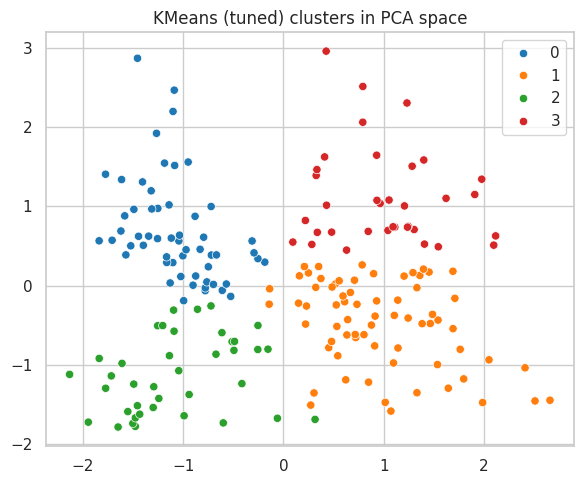

In [ ]:
# 12b. KMeans extended tuning (init, n_init, algorithm, max_iter, PCA variants)
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score

def prepare_space(X_arr, mode):
    if mode == 'raw':
        return X_arr, {'preproc':'raw'}
    if mode == 'pca2':
        p = PCA(n_components=2, random_state=RANDOM_STATE)
        return p.fit_transform(X_arr), {'preproc':'pca2','explained':p.explained_variance_ratio_.sum()}
    if mode == 'pca3':
        p = PCA(n_components=3, random_state=RANDOM_STATE)
        return p.fit_transform(X_arr), {'preproc':'pca3','explained':p.explained_variance_ratio_.sum()}
    if mode == 'pca2_whiten':
        p = PCA(n_components=2, whiten=True, random_state=RANDOM_STATE)
        return p.fit_transform(X_arr), {'preproc':'pca2_whiten','explained':p.explained_variance_ratio_.sum()}
    raise ValueError(mode)

X_arr = X.toarray() if hasattr(X, 'toarray') else X
k_candidates = sorted({max(2, (locals().get('best_k', 6) - 1)), locals().get('best_k', 6), (locals().get('best_k', 6) + 1), 4,5,6,7,8})
inits = ['k-means++','random']
algorithms = ['lloyd','elkan']
n_inits = [20, 50, 100]
max_iters = [300, 1000]
spaces = ['raw','pca2','pca3','pca2_whiten']

rows = []
for space in spaces:
    X_km, meta = prepare_space(X_arr, space)
    for k in k_candidates:
        for init in inits:
            for alg in algorithms:
                for n_init in n_inits:
                    for mi in max_iters:
                        km = KMeans(n_clusters=k, init=init, n_init=n_init, algorithm=alg, max_iter=mi, random_state=RANDOM_STATE)
                        y = km.fit_predict(X_km)
                        # metrics
                        if len(np.unique(y)) < 2:
                            continue
                        sil = float(silhouette_score(X_km, y))
                        dbi = float(davies_bouldin_score(X_km, y))
                        ch = float(calinski_harabasz_score(X_km, y))
                        counts = pd.Series(y).value_counts().sort_index()
                        balance = float(counts.min()/counts.max()) if len(counts)>1 else 0.0
                        rows.append({
                            'space': meta['preproc'],
                            'k': k,
                            'init': init,
                            'algorithm': alg,
                            'n_init': n_init,
                            'max_iter': mi,
                            'silhouette': sil,
                            'davies_bouldin': dbi,
                            'calinski_harabasz': ch,
                            'balance_min_max': balance,
                            'explained_var': meta.get('explained', np.nan)
                        })

km_df = pd.DataFrame(rows)
if not km_df.empty:
    km_df = km_df.assign(rank_key=-km_df['silhouette'] + 0.001*km_df['davies_bouldin'] - 0.00001*km_df['calinski_harabasz'])
    display(km_df.sort_values('rank_key').head(15))
    best_row = km_df.sort_values('rank_key').iloc[0]
    print('\nSelected best KMeans config:')
    print(best_row.to_dict())
    # Refit on its space and attach tuned labels
    X_best, _ = prepare_space(X_arr, best_row['space'])
    km_best = KMeans(n_clusters=int(best_row['k']), init=best_row['init'], n_init=int(best_row['n_init']), algorithm=best_row['algorithm'], max_iter=int(best_row['max_iter']), random_state=RANDOM_STATE)
    labels_tuned = km_best.fit_predict(X_best)
    df['Cluster_KMeans_Tuned'] = labels_tuned
    # Agreement with previous KMeans (if present)
    if 'labels_km' in locals():
        try:
            ari = adjusted_rand_score(labels_km, labels_tuned)
            print(f'ARI vs earlier KMeans labels: {ari:.3f}')
        except Exception as e:
            print('Could not compute ARI vs earlier KMeans:', e)
    # Quick PCA plot in original PCA space for visualization
    import seaborn as sns, matplotlib.pyplot as plt
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_tuned, palette='tab10')
    plt.title('KMeans (tuned) clusters in PCA space')
    plt.tight_layout()
    plt.show()
else:
    print('No KMeans tuning results computed.')

## 13. References
- scikit-learn Clustering: https://scikit-learn.org/stable/modules/clustering.html
- scikit-learn Mixture Models: https://scikit-learn.org/stable/modules/mixture.html
- scikit-learn Manifold Learning (t-SNE): https://scikit-learn.org/stable/modules/manifold.html#t-sne
- UMAP: https://umap-learn.readthedocs.io/en/latest/
- Kaggle: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

## 14. Report: PowerPoint deck
This section generates a concise presentation covering data, methods, model selection, results, tuning highlights, and business insights. The deck will be saved in the project root.

In [31]:
# Generate PowerPoint report
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN
from datetime import datetime
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

BASE_DIR = Path.cwd()
assets_dir = BASE_DIR / 'report_assets'
assets_dir.mkdir(exist_ok=True)

# Helper to (re)create key figures
def fig_elbow_silhouette(X):
    k_values = list(range(2, 11))
    inertias, sils = [], []
    for k in k_values:
        km = KMeans(n_clusters=k, n_init='auto', random_state=RANDOM_STATE)
        y = km.fit_predict(X)
        inertias.append(km.inertia_)
        try:
            sils.append(silhouette_score(X, y))
        except Exception:
            sils.append(np.nan)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(k_values, inertias, marker='o')
    ax[0].set_title('Elbow (Inertia)')
    ax[0].set_xlabel('k'); ax[0].set_ylabel('Inertia')
    ax[1].plot(k_values, sils, marker='o', color='green')
    ax[1].set_title('Silhouette vs k')
    ax[1].set_xlabel('k'); ax[1].set_ylabel('Silhouette')
    plt.tight_layout()
    path = assets_dir / 'elbow_silhouette.png'
    fig.savefig(path, dpi=160)
    plt.close(fig)
    return path

def fig_pca_kmeans(X_pca, labels):
    fig = plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='tab10', s=40, edgecolor='white', linewidth=0.3)
    plt.title('KMeans clusters in PCA space')
    plt.tight_layout()
    path = assets_dir / 'pca_kmeans.png'
    fig.savefig(path, dpi=160)
    plt.close(fig)
    return path

def fig_method_silhouette(metrics_df):
    if metrics_df is None or len(metrics_df)==0:
        return None
    m = metrics_df.sort_values('silhouette', ascending=True)
    fig = plt.figure(figsize=(5,3.2))
    plt.barh(m['method'], m['silhouette'], color='#4C78A8')
    plt.xlabel('Silhouette (higher is better)')
    plt.title('Method comparison')
    plt.tight_layout()
    path = assets_dir / 'method_silhouette.png'
    fig.savefig(path, dpi=160)
    plt.close(fig)
    return path

# Ensure variables exist
try:
    _ = labels_km
except NameError:
    km = KMeans(n_clusters=int(locals().get('best_k', 6)), n_init='auto', random_state=RANDOM_STATE)
    labels_km = km.fit_predict(X)
    df['Cluster_KMeans'] = labels_km

# Build or refresh figures
p1 = fig_elbow_silhouette(X)
p2 = fig_pca_kmeans(X_pca, labels_km)
p3 = fig_method_silhouette(locals().get('metrics_df'))

# Metrics summary
def first_or_none(df_like, method_name):
    try:
        row = df_like[df_like['method']==method_name].iloc[0]
        return row
    except Exception:
        return None

metrics_summary = {}
mdf = locals().get('metrics_df')
if isinstance(mdf, pd.DataFrame) and not mdf.empty:
    for name in ['KMeans','Agglomerative','GMM','DBSCAN']:
        r = first_or_none(mdf, name)
        if r is not None:
            metrics_summary[name] = {
                'silhouette': float(r['silhouette']),
                'davies_bouldin': float(r['davies_bouldin']),
                'calinski_harabasz': float(r['calinski_harabasz']) if 'calinski_harabasz' in r else None
            }

# Insights text (fallback if labels_map not rich)
insights_points = [
    'KMeans (k=6) chosen for production: simple, stable, strong silhouette; clear segments.',
    'GMM (k=6) performs similarly; use for soft membership probabilities.',
    'DBSCAN highlights dense pockets/outliers; not used for full segmentation.',
    'Personas: VIPs; Under-engaged Affluents; Trend-driven Youth; Budget-conscious; Young Mainstream; Quality/Comfort-focused.'
]

# Build deck
prs = Presentation()
# Title slide
title_slide_layout = prs.slide_layouts[0]
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'Mall Customers Segmentation — Summary'
slide.placeholders[1].text = f"Generated on {datetime.now().strftime('%Y-%m-%d')}"

# Data overview
layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(layout)
slide.shapes.title.text = 'Data overview'
tf = slide.placeholders[1].text_frame
tf.clear()
p = tf.paragraphs[0]
p.text = f"Rows: {len(df)} | Features used: {', '.join([*numeric_features, *categorical_features])}"
p.level = 0
p = tf.add_paragraph(); p.text = 'Preprocessing: median-impute numerics, most-frequent for categoricals, one-hot encode Gender, standardize'; p.level = 0
na_total = int(df.isna().sum().sum())
p = tf.add_paragraph(); p.text = f'Missing values (post-load): {na_total}'; p.level = 0

# Methods tried
slide = prs.slides.add_slide(layout)
slide.shapes.title.text = 'Methods evaluated'
tf = slide.placeholders[1].text_frame
tf.clear()
for line in ['KMeans (k selection by silhouette/elbow)', 'Agglomerative (ward/complete/average)', 'Gaussian Mixture (AIC/BIC + silhouette)', 'DBSCAN (density-based; outliers)']:
    para = tf.add_paragraph() if tf.text else tf.paragraphs[0]
    if not tf.text:
        tf.text = line
    else:
        para.text = line
    para.level = 0

# Model selection visuals
slide = prs.slides.add_slide(prs.slide_layouts[5])  # Title Only
slide.shapes.title.text = 'Model selection'
left = Inches(0.5)
top = Inches(1.2)
if p1 and Path(p1).exists():
    slide.shapes.add_picture(str(p1), left, top, height=Inches(3.3))
if p3 and Path(p3).exists():
    slide.shapes.add_picture(str(p3), left+Inches(5.2), top, height=Inches(3.3))

# Best model details
slide = prs.slides.add_slide(layout)
slide.shapes.title.text = 'Best model'
tf = slide.placeholders[1].text_frame
tf.clear()
k_sel = int(locals().get('best_k', 6))
p = tf.paragraphs[0]
p.text = f'Chosen: KMeans (k={k_sel})'
p.level = 0
if 'sil_km' in locals():
    tf.add_paragraph().text = f'Silhouette: {sil_km:.3f}'; tf.paragraphs[-1].level = 0
    tf.add_paragraph().text = f'Davies–Bouldin: {dbi_km:.3f}'; tf.paragraphs[-1].level = 0
if isinstance(mdf, pd.DataFrame) and 'GMM' in (mdf['method'].unique() if not mdf.empty else []):
    r = first_or_none(mdf, 'GMM')
    if r is not None:
        tf.add_paragraph().text = f'GMM (k={k_sel}) silhouette≈{float(r.silhouette):.3f}, DBI≈{float(r.davies_bouldin):.3f}'
        tf.paragraphs[-1].level = 1

# PCA clusters image
slide = prs.slides.add_slide(prs.slide_layouts[5])
slide.shapes.title.text = 'Clusters (PCA view)'
if p2 and Path(p2).exists():
    slide.shapes.add_picture(str(p2), Inches(1.2), Inches(1.5), height=Inches(4.5))

# Tuning highlights
slide = prs.slides.add_slide(layout)
slide.shapes.title.text = 'Tuning highlights'
tf = slide.placeholders[1].text_frame
tf.clear()
# From sweeps if available
best_table = locals().get('best')
if isinstance(best_table, pd.DataFrame) and not best_table.empty:
    for mname, row in best_table.iterrows():
        para = tf.add_paragraph() if tf.text else tf.paragraphs[0]
        if not tf.text:
            tf.text = f"{mname}: silhouette={row['silhouette']:.3f}, DBI={row['davies_bouldin']:.3f}"
        else:
            para.text = f"{mname}: silhouette={row['silhouette']:.3f}, DBI={row['davies_bouldin']:.3f}"
        para.level = 0
else:
    tf.text = 'See notebook Section 12 for grid results (silhouette/DBI/CH).'
    tf.paragraphs[0].level = 0

# Insights & actions
slide = prs.slides.add_slide(layout)
slide.shapes.title.text = 'Insights & actions'
tf = slide.placeholders[1].text_frame
tf.clear()
for idx, line in enumerate(insights_points):
    para = tf.add_paragraph() if idx>0 else tf.paragraphs[0]
    para.text = line
    para.level = 0

# Save deck
ppt_path = BASE_DIR / 'mall_customers_segmentation_summary.pptx'
prs.save(ppt_path)
print(f'PowerPoint written to: {ppt_path}')

PowerPoint written to: /mnt/c/Users/crawfpi/OneDrive - Chevron/Academics/MSC CS/MLWithPython/UnsupervisedLearning/Module5/mall_customers_segmentation_summary.pptx
